In [1]:
from google import colab
colab.drive.mount('/content/gdrive')
import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.stats import hmean

import shutil

Mounted at /content/gdrive


# Load predictions

In [4]:
display(df_res_kev.head())

,resnet_gblur2_split1_cv_1_pred,resnet_gblur2_split1_cv_2_pred,resnet_gblur4_split2_cv_1_pred,resnet_gblur4_split2_cv_2_pred,resnext_l2reg_split2_cv_0_pred,resnext_l2reg_split2_cv_1_pred,resnext_l2reg_split2_cv_2_pred,resnet_l2reg_split2_cv_1_pred,resnet_l2reg_split2_cv_2_pred,resnext_split3_cv_0_pred,resnext_split3_cv_1_pred,resnext_split3_cv_2_pred,resnet_gblur4_split3_cv_0_pred,resnet_gblur4_split3_cv_1_pred,resnet_gblur4_split3_cv_2_pred,pred_mean,pred_hmean,pred_var,id
0,2.796836,7.841290,8.163745,6.893949,4.887791,8.491408,4.492164,6.009198,20.746948,9.617138,7.197741,5.848840,5.776880,9.321598,3.318530,7.426937,5.981313,16.572917,00013a94f1fae3e5a33f8b44c2842c85f0483e96
1,29.253424,18.672964,21.554422,13.497818,20.213717,26.909615,15.853285,16.864912,29.516575,13.957528,19.334311,25.245836,12.715466,25.618490,21.962570,20.744729,19.297781,29.473118,0005564c011259402dcb6e3beb6e64d285124fa0
2,22.390299,22.090170,25.887194,15.004934,24.175655,34.369297,20.702347,22.469183,30.138819,36.807781,18.989801,30.914879,23.632669,27.684202,24.551973,25.320614,24.077261,31.598469,0007520c8d8efade8feaafbf74fc7d206cdf229d
3,0.879673,2.977322,0.957411,4.292737,2.637580,2.083497,0.826312,1.111539,19.469427,5.273226,1.023773,1.790506,2.561021,0.976321,0.953621,3.187598,1.506224,20.621857,000804a189f630cd980ff1543c0ef99d48cd6b34
4,22.037849,22.202860,25.676832,15.111387,23.740814,34.628750,20.843821,22.849161,29.675219,35.431068,18.387745,30.843887,23.983091,27.899891,24.391420,25.180253,23.979248,29.926911,000eb12def5371089743dcfe401a8e399f5883fc


In [8]:
df_res_class = pd.read_csv('/content/gdrive/MyDrive/IDAO/clean_code/class_pred.csv')
df_res_class.rename(columns={'pred_mean':'pred_mean_class','pred_hmean':'pred_hmean_class','pred_var':'pred_var_class'},inplace=True)

df_res_kev = pd.read_csv('/content/gdrive/MyDrive/IDAO/clean_code/kev_pred.csv')
df_res_kev.rename(columns={'pred_mean':'pred_mean_kev','pred_hmean':'pred_hmean_kev','pred_var':'pred_var_kev'},inplace=True)

df_res = pd.merge(df_res_class[['id','pred_mean_class','pred_hmean_class','pred_var_class']], df_res_kev[['id','pred_mean_kev','pred_hmean_kev','pred_var_kev']], on='id')

display(df_res.head())

,id,pred_mean_class,pred_hmean_class,pred_var_class,pred_mean_kev,pred_hmean_kev,pred_var_kev
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,0.962471,8.566864e-01,0.023648,7.426937,5.981313,16.572917
1,0005564c011259402dcb6e3beb6e64d285124fa0,0.981674,9.691458e-01,0.006480,20.744729,19.297781,29.473118
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0.464938,5.089538e-08,0.204144,25.320614,24.077261,31.598469
3,000804a189f630cd980ff1543c0ef99d48cd6b34,0.055866,7.938800e-05,0.018489,3.187598,1.506224,20.621857
4,000eb12def5371089743dcfe401a8e399f5883fc,0.471066,2.258597e-07,0.199787,25.180253,23.979248,29.926911


# utils

In [13]:
def cluster_to_kev_valid(clusters, pred_class):
    if pred_class == 1:
        list_kev = [1, 6, 20]
    else:
        list_kev = [3, 10, 30]

    clusters_rank = [sorted(clusters).index(x) for x in clusters]
    replace_dict = {
        0: list_kev[clusters_rank[0]],
        1: list_kev[clusters_rank[1]],
        2: list_kev[clusters_rank[2]]
    }
    return replace_dict


def adjust_class(df_res, class_to_adjust, col_class_pred='pred_hmean_class', col_class_var='pred_var_class'):
    tmp_res = df_res.loc[df_res.cluster_pred_hmean_kev == class_to_adjust]
    change_needed = tmp_res.shape[0] - 2512
    if class_to_adjust in [3, 10, 30]:
        change_index = tmp_res.sort_values(by=['pred_mean_class', 'pred_var_class'], ascending=False).index.values[
                       :change_needed]
        df_res['post_class'] = df_res[col_class_pred].values
        df_res['post_var_class'] = df_res[col_class_var].values
        for i in tqdm(change_index, position=0):
            pred_mean = df_res.iloc[i].pred_mean_class
            df_res.at[i, 'post_class'] = max([0.6, pred_mean])
            df_res.at[i, 'post_var_class'] = 0.01
    else:
        change_index = tmp_res.sort_values(by=['pred_mean_class', 'pred_var_class'], ascending=True).index.values[
                       :change_needed]
        df_res['post_class'] = df_res[col_class_pred].values
        df_res['post_var_class'] = df_res[col_class_var].values
        for i in tqdm(change_index, position=0):
            pred_mean = df_res.iloc[i].pred_mean_class
            df_res.at[i, 'post_class'] = min([0.4, pred_mean])
            df_res.at[i, 'post_var_class'] = 0.01

    df_res.head()
    return df_res


def kmeans_clusters(df_res, col_split, val_split=0.5):
    tmp_0 = df_res.loc[df_res[col_split] < val_split].copy()
    tmp_1 = df_res.loc[df_res[col_split] > val_split].copy()
    for col_kev in ['pred_mean_kev', 'pred_hmean_kev']:
        kmeans_0 = KMeans(n_clusters=3, random_state=0).fit(tmp_0[col_kev].values.reshape(-1, 1))
        kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(tmp_1[col_kev].values.reshape(-1, 1))
        tmp_0[f'post_cluster_{col_kev}'] = kmeans_0.labels_
        tmp_1[f'post_cluster_{col_kev}'] = kmeans_1.labels_
        replace_0 = cluster_to_kev_valid(kmeans_0.cluster_centers_[:, 0], 0)
        replace_1 = cluster_to_kev_valid(kmeans_1.cluster_centers_[:, 0], 1)
        tmp_0[f'post_cluster_{col_kev}'].replace(replace_0, inplace=True)
        tmp_1[f'post_cluster_{col_kev}'].replace(replace_1, inplace=True)
    tmp_res = pd.concat([tmp_0, tmp_1])
    return tmp_res

# Initial kmeans clustering

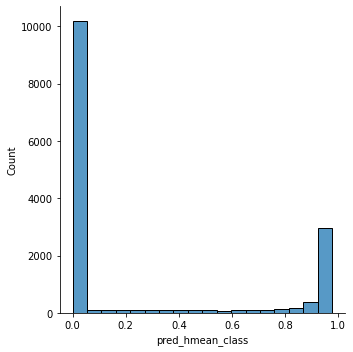

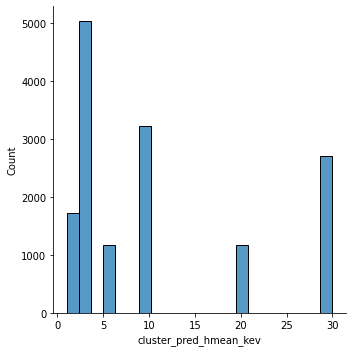

In [11]:
tmp_0 = df_res.loc[df_res.pred_hmean_class<0.5].copy()
tmp_1 = df_res.loc[df_res.pred_hmean_class>0.5].copy()

for col_kev in ['pred_mean_kev','pred_hmean_kev']:
  kmeans_0 = KMeans(n_clusters=3, random_state=0).fit(tmp_0[col_kev].values.reshape(-1,1))
  kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(tmp_1[col_kev].values.reshape(-1,1))

  tmp_0[f'cluster_{col_kev}'] = kmeans_0.labels_
  tmp_1[f'cluster_{col_kev}'] = kmeans_1.labels_

  replace_0 = cluster_to_kev_valid(kmeans_0.cluster_centers_[:,0],0)
  replace_1 = cluster_to_kev_valid(kmeans_1.cluster_centers_[:,0],1)

  tmp_0[f'cluster_{col_kev}'].replace(replace_0, inplace=True)
  tmp_1[f'cluster_{col_kev}'].replace(replace_1, inplace=True)

  tmp_res = pd.concat([tmp_0,tmp_1])

df_res = tmp_res.copy()

# Show class unbalances
sns.displot(df_res.pred_hmean_class)
sns.displot(df_res.cluster_pred_hmean_kev)

# unbalance correction

  0%|          | 0/2529 [00:00<?, ?it/s]

[3, 10, 30]
chanfge needed


100%|██████████| 721/721 [00:00<00:00, 4651.54it/s]

chanfge needed



100%|██████████| 195/195 [00:00<00:00, 4697.27it/s]

chanfge needed


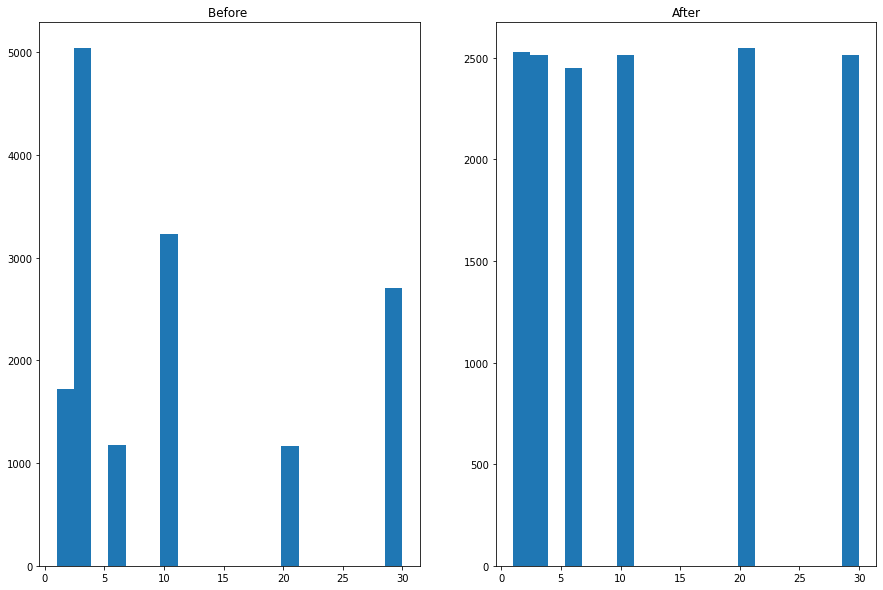

In [12]:
classes_to_adjust = []
classes_size = []

for i in [1, 3, 6, 10, 20, 30]:
  if df_res.loc[df_res.cluster_pred_hmean_kev==i].shape[0]>2600:
    classes_size += [df_res.loc[df_res.cluster_pred_hmean_kev==i].shape[0]]
    classes_to_adjust += [i]
print(classes_to_adjust)
size_rank = [sorted(classes_size)[::-1].index(x) for x in classes_size]

df_res['post_class'] = df_res.pred_hmean_class.values
df_res['post_var_class'] = df_res.pred_var_class.values
df_res['post_cluster_pred_hmean_kev'] = df_res.cluster_pred_hmean_kev.values

df_res_adj = df_res.copy()
for idx in size_rank:
  class_to_adjust = classes_to_adjust[idx]
  df_res_adj = adjust_class(df_res_adj.copy(),class_to_adjust=class_to_adjust,col_class_pred='post_class',col_class_var='post_var_class')
  df_res_adj = kmeans_clusters(df_res_adj.copy(),'post_class',.5)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Before ')
plt.hist(df_res.post_cluster_pred_hmean_kev,bins=20)
plt.subplot(1,2,2)
plt.title('After')
plt.hist(df_res_adj.post_cluster_pred_hmean_kev,bins=20)
plt.show()

# Make the submission

In [17]:
df_public = pd.read_csv('/content/gdrive/MyDrive/IDAO/clean_code/public_test_sub.csv')
df_res_adj.rename(columns={'pred_hmean_class':'classification_predictions','post_cluster_pred_hmean_kev':'regression_predictions'},inplace=True)
df_res_adj = df_res_adj[['id','classification_predictions','regression_predictions']]
df = pd.concat([df_public,df_res_adj])
df.head()
df.to_csv('/content/gdrive/MyDrive/IDAO/clean_code/final_sub.csv',index=False)